# 1. 이해하기

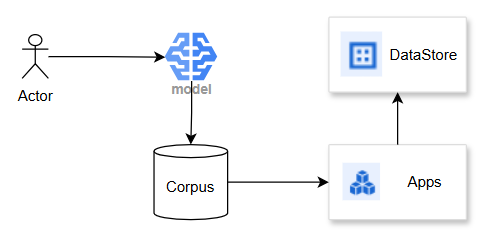

# 2. 구현하기

## 2.1 Datastore 만들기

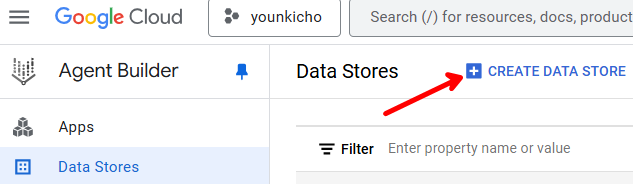

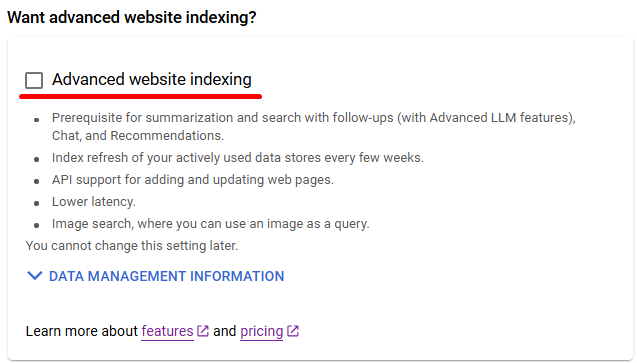

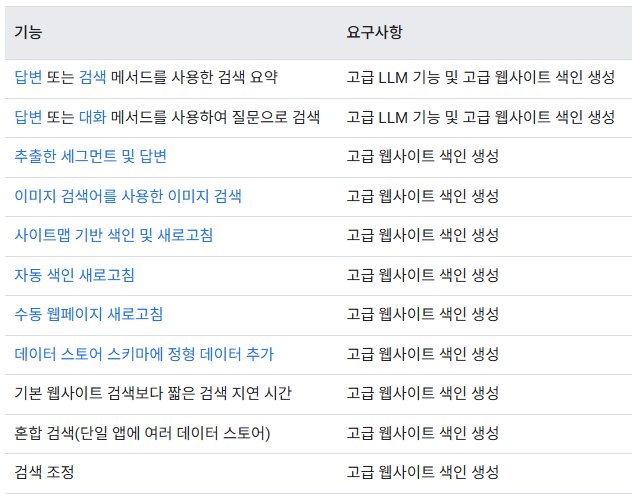

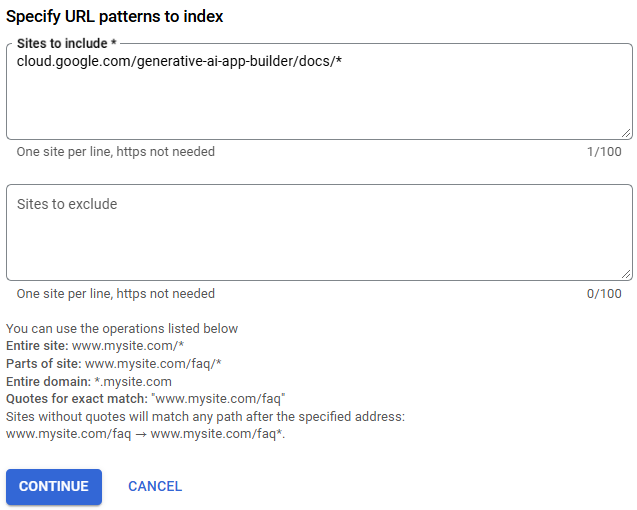

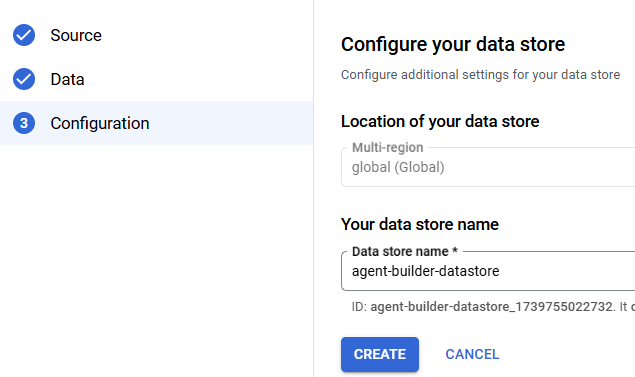

## 2.2 App 만들기

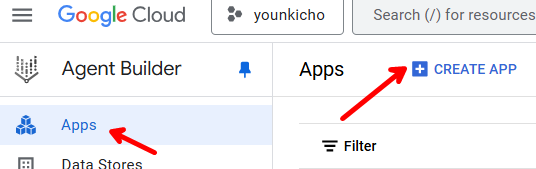

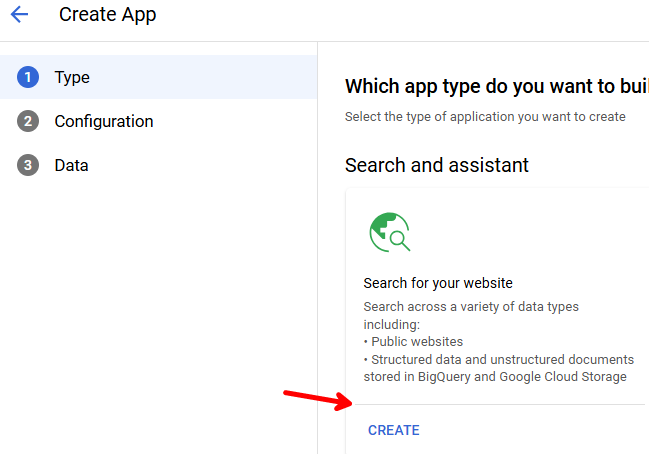

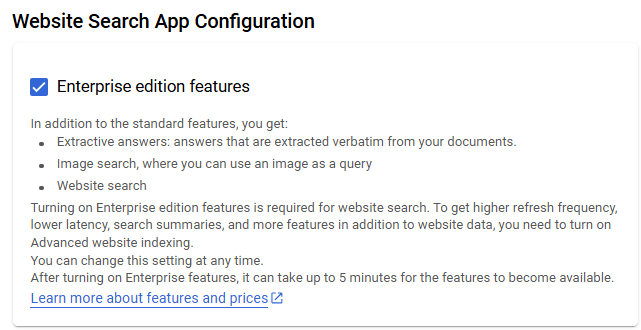

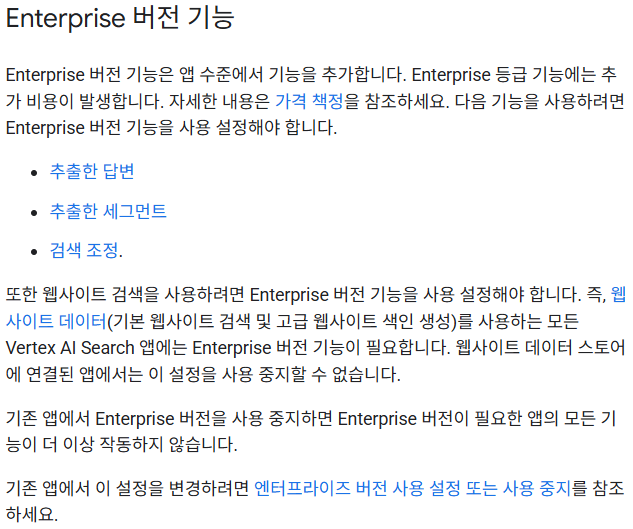

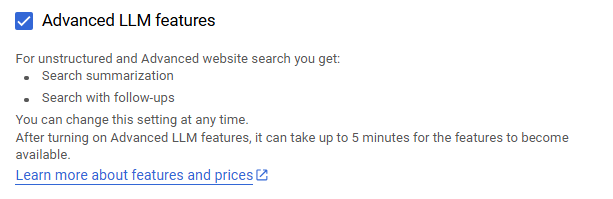

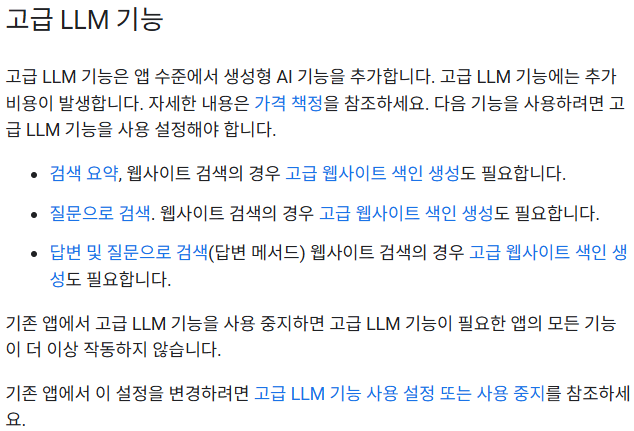

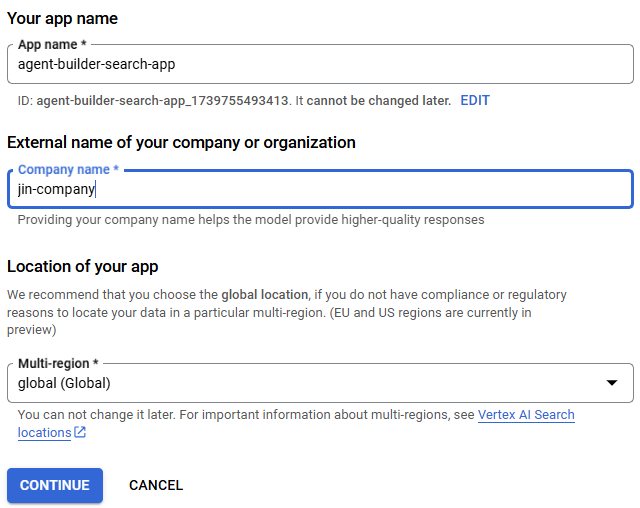

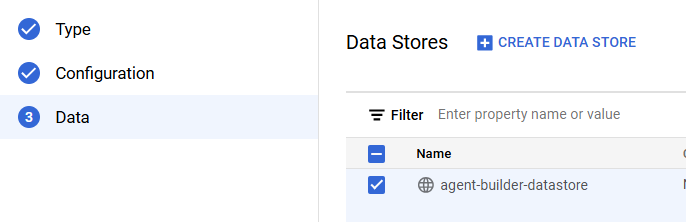

## 2.3 결과 확인

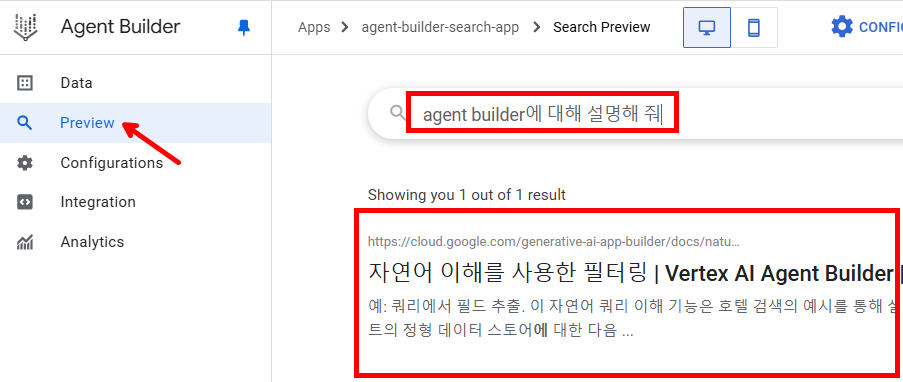

# 3. 모델 연동

## 3.1 환경설정

In [ ]:
!pip install google-cloud-discoveryengine

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 26.6 MB/s eta 0:00:00


In [ ]:
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [ ]:
import os

PROJECT_ID=os.environ.get("GOOGLE_CLOUD_PROJECT")
LOCATION = os.environ.get("GOOGLE_CLOUD_REGION", "us-central1")

In [ ]:
import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

In [ ]:
from google.cloud import discoveryengine
from google.api_core.client_options import ClientOptions

In [ ]:
from vertexai.preview import rag
from vertexai.preview.generative_models import GenerativeModel, Tool

## 3.2 Corpus 만들기

In [ ]:
class Corpus:
  def __init__(self, project_id, location):
    self.project_id = project_id
    self.location = location

    client_options = (
        ClientOptions(api_endpoint=f"{location}-discoveryengine.googleapis.com")
        if location != "global"
        else None
    )
    self.client = discoveryengine.EngineServiceClient(client_options=client_options)

  def create_corpus(self, engine_id, rag_name):
    parent = self.client.engine_path(
        self.project_id,
        self.location,
        "default_collection"
        , engine_id)
    vertex_ai_search_config = rag.VertexAiSearchConfig(
      serving_config=f"{parent}/servingConfigs/default_search",
    )

    return rag.create_corpus(
        display_name=rag_name,
        vertex_ai_search_config=vertex_ai_search_config,
    )

  def delete_engine(self):
    corpus_list=rag.list_corpora()

    for corpus in corpus_list:
      rag.delete_corpus(name=corpus.name)

In [ ]:
CORPUS_LOCATION="global"
ENGINE_ID="agent-builder-search-app_1739755493413"
CORPUS_NAME="agent-builder-corpus"

In [ ]:
_corpus = Corpus(PROJECT_ID, CORPUS_LOCATION)

In [ ]:
rag_corpus = _corpus.create_corpus(ENGINE_ID, CORPUS_NAME)

In [ ]:
GENERATE_CONTENT_PROMPT="""
agent builder는?
"""

In [ ]:
rag_resource = rag.RagResource(rag_corpus=rag_corpus.name)

response = rag.retrieval_query(
    rag_resources=[rag_resource],
    text=GENERATE_CONTENT_PROMPT,
    similarity_top_k=10,  # Optional
    vector_distance_threshold=1,  # Optional
    # vector_search_alpha=0.5, # Optional - Only supported for Weaviate
)

print(response)

contexts {
  contexts {
    source_uri: "https://cloud.google.com/generative-ai-app-builder/docs/turn-off-enterprise-search?hl=ko"
    source_display_name: "Vertex AI Agent Builder 사용 중지 | Google Cloud"
    text: "Vertex AI Agent Builder는 Discovery Engine API를 기반으로 합니다. Vertex AI Agent Builder를 사용 중지하려면 다음 단계를 따르세요. Google Cloud 콘솔에서 ..."
  }
  contexts {
    source_uri: "https://cloud.google.com/generative-ai-app-builder/docs/responsible-ai?hl=ko"
    source_display_name: "책임감 있는 AI | Vertex AI Agent Builder | Google Cloud"
    text: "이러한 위험과 복잡성을 고려하여 Vertex AI Agent Builder는 Google의 AI 원칙을 염두에 두고 설계되었습니다. 그러나 개발자가 이를 이해하고 안전하고 책임감 있는 ..."
  }
  contexts {
    source_uri: "https://cloud.google.com/generative-ai-app-builder/docs/cmek?hl=ko"
    source_display_name: "고객 관리 암호화 키 | Vertex AI Agent Builder | Google Cloud"
    text: "이 페이지에서는 자체 암호화 키를 사용하여 미국 및 EU 멀티 리전에 있는 데이터 스토어를 보호하는 방법을 설명합니다. 기본적으로 Vertex AI Agent Builder는 ..."
  }
  contexts {
    source_uri: "https://cloud.google

## 3.3 모델 연동

In [ ]:
from IPython.display import Markdown, display

In [ ]:
rag_resource = rag.RagResource(rag_corpus=rag_corpus.name)
source=rag.VertexRagStore(
    rag_resources=[rag_resource],  # Currently only 1 corpus is allowed.
    similarity_top_k=10,
)
retrieval=rag.Retrieval(source=source)
rag_retrieval_tool = Tool.from_retrieval(retrieval = retrieval)

rag_model = GenerativeModel(
    "gemini-1.5-flash",
    tools=[rag_retrieval_tool])

In [ ]:
GENERATE_CONTENT_PROMPT="""
agent builder는?
"""

In [ ]:
response = rag_model.generate_content(GENERATE_CONTENT_PROMPT)

display(Markdown(response.text))

Agent Builder는 구글 클라우드의 새로운 자연어 이해 플랫폼입니다. 이 플랫폼은 대규모 언어 모델(LLM)을 기반으로 하며, 대화형 에이전트를 쉽게 디자인하고 배포할 수 있도록 돕습니다. 


In [ ]:
GENERATE_CONTENT_PROMPT="""
Agent builder의 고급기능이란?
"""

In [ ]:
response = rag_model.generate_content(GENERATE_CONTENT_PROMPT)

display(Markdown(response.text))

Vertex AI Agent Builder의 고급 기능은 검색 앱에서 다양한 고급 기능을 사용할 수 있도록 합니다.  고급 LLM 기능은 검색 요약 또는 질문으로 검색과 같은 기능을 활성화하는 데 필요합니다. 또한, 웹사이트 색인 생성, 데이터 스토어, 웹사이트 데이터 스토어 연결과 같은 다양한 옵션을 제공합니다. 


# 4. resource 정리

## 4.1 corpus 삭제

In [ ]:
_corpus.delete_engine()

Successfully deleted the RagCorpus.


## 4.2 Rag Engine 삭제

In [ ]:
LOCATION="global"

In [ ]:
client_options = (
    ClientOptions(api_endpoint=f"{LOCATION}-discoveryengine.googleapis.com")
    if LOCATION != "global"
    else None
)

In [ ]:
client = discoveryengine.DataStoreServiceClient(client_options=client_options)
collection_path = client.collection_path(
    PROJECT_ID,
    LOCATION,
    "default_collection"
)

In [ ]:
client = discoveryengine.EngineServiceClient(client_options=client_options)

# Initialize request argument(s)
request = discoveryengine.ListEnginesRequest(
    parent=collection_path,
)

# Make the request
page_result = client.list_engines(request=request)

# Handle the response
for response in page_result:
    client.delete_engine(name=response.name)

## 4.3 Datastore 삭제

In [ ]:
client = discoveryengine.DataStoreServiceClient(client_options=client_options)
collection_path = client.collection_path(
    PROJECT_ID,
    LOCATION,
    "default_collection"
)
request = discoveryengine.ListDataStoresRequest(
        parent=collection_path
    )

# Make the request
page_result = client.list_data_stores(request=request)

# Handle the response
for response in page_result:
  print(response.name)
  client.delete_data_store(name=response.name)

projects/429718924597/locations/global/collections/default_collection/dataStores/agent-builder-datastore_1739755022732
projects/429718924597/locations/global/collections/default_collection/dataStores/alphabet-contracts-datastore-id1
projects/429718924597/locations/global/collections/default_collection/dataStores/bigquery_data_store
projects/429718924597/locations/global/collections/default_collection/dataStores/kpi-datastore_1739761264761
projects/429718924597/locations/global/collections/default_collection/dataStores/public-web-datastore
projects/429718924597/locations/global/collections/default_collection/dataStores/web-datastore


* https://cloud.google.com/python/docs/reference/discoveryengine/latest/google.cloud.discoveryengine_v1.services.engine_service.EngineServiceClient#google_cloud_discoveryengine_v1_services_engine_service_EngineServiceClient_list_engines
* https://cloud.google.com/python/docs/reference/discoveryengine/latest/google.cloud.discoveryengine_v1.services.data_store_service.DataStoreServiceClient#google_cloud_discoveryengine_v1_services_data_store_service_DataStoreServiceClient_list_data_stores
* https://cloud.google.com/python/docs/reference/discoveryengine/latest/google.cloud.discoveryengine_v1.types.ListEnginesRequest
